<a href="https://colab.research.google.com/github/Triqster25/Riset-Informatika-C081-21081010131-Muhammad-Utbah-Husnuth-Thoriq/blob/main/program_riset_infor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import cv2
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np

In [4]:
# Fungsi untuk mengunggah file
print("Unggah gambar latih (banyak) dan gambar uji (satu)...")
uploaded = files.upload()

Unggah gambar latih (banyak) dan gambar uji (satu)...


Saving test_RaOneposter.jpg to test_RaOneposter.jpg
Saving tt0084058.jpg to tt0084058.jpg
Saving tt0084867.jpg to tt0084867.jpg
Saving tt0085121.jpg to tt0085121.jpg
Saving tt0085154.jpg to tt0085154.jpg
Saving tt0085159.jpg to tt0085159.jpg
Saving tt0085208.jpg to tt0085208.jpg
Saving tt0085236.jpg to tt0085236.jpg
Saving tt0085244.jpg to tt0085244.jpg
Saving tt0085248.jpg to tt0085248.jpg
Saving tt0085255.jpg to tt0085255.jpg
Saving tt0085271.jpg to tt0085271.jpg
Saving tt0085276.jpg to tt0085276.jpg
Saving tt0085318.jpg to tt0085318.jpg
Saving tt0085320.jpg to tt0085320.jpg
Saving tt0085333.jpg to tt0085333.jpg
Saving tt0085334.jpg to tt0085334.jpg
Saving tt0085346.jpg to tt0085346.jpg
Saving tt0085382.jpg to tt0085382.jpg
Saving tt0085384.jpg to tt0085384.jpg
Saving tt0085387.jpg to tt0085387.jpg
Saving tt0085398.jpg to tt0085398.jpg
Saving tt0085407.jpg to tt0085407.jpg
Saving tt0085412.jpg to tt0085412.jpg
Saving tt0085450.jpg to tt0085450.jpg
Saving tt0085461.jpg to tt0085461.jp

In [5]:
# Memisahkan file latih dan uji
train_files = {name: cv2.imread(name, cv2.IMREAD_GRAYSCALE) for name in uploaded.keys() if "test" not in name}
test_file = {name: cv2.imread(name, cv2.IMREAD_GRAYSCALE) for name in uploaded.keys() if "test" in name}

In [6]:
# Pastikan ada gambar uji
if not test_file:
    raise ValueError("Gambar uji tidak ditemukan! Pastikan file uji mengandung kata 'test' dalam namanya.")
test_image_name, test_img = next(iter(test_file.items()))

In [7]:
# Resize gambar uji
test_img = cv2.resize(test_img, (500, 500))  # Resize ke ukuran seragam
sift = cv2.SIFT_create()
test_keypoints, test_descriptors = sift.detectAndCompute(test_img, None)

In [8]:
# Memproses gambar latih
print("Memproses semua gambar latih...")
train_images = []
train_descriptors = []
train_keypoints = []

Memproses semua gambar latih...


In [9]:
for filename, img in train_files.items():
    img = cv2.resize(img, (500, 500))  # Resize ke ukuran seragam
    keypoints, descriptors = sift.detectAndCompute(img, None)
    train_images.append((filename, img, keypoints))
    train_descriptors.append(descriptors)

In [10]:
# Membandingkan gambar uji dengan semua gambar latih
print("Mencocokkan gambar uji dengan gambar latih...")
flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))

Mencocokkan gambar uji dengan gambar latih...


In [11]:
match_counts = []  # Untuk menyimpan jumlah fitur cocok dengan setiap gambar latih
for (filename, train_img, train_keypoints), train_desc in zip(train_images, train_descriptors):
    matches = flann.knnMatch(test_descriptors, train_desc, k=2)

    # Ratio test untuk menyaring pencocokan buruk
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Simpan jumlah fitur cocok
    match_counts.append((filename, len(good_matches)))

In [12]:
# Evaluasi dengan Penyesuaian Ambang Batas
print("Evaluasi dengan penyesuaian ambang batas...")
true_labels = [1, 0, 1, 1, 0, 0, 1, 0, 1, 0]  # 1 = plagiasi, 0 = non-plagiasi
simulated_matches = [count for _, count in match_counts]  # Menggunakan jumlah fitur cocok

thresholds = range(10, 50, 5)
f1_scores = []

for threshold in thresholds:
    predicted_labels = [1 if matches > threshold else 0 for matches in simulated_matches]

    # Menghitung TP, FP, TN, FN
    TP = sum([1 for t, p in zip(true_labels, predicted_labels) if t == 1 and p == 1])
    FP = sum([1 for t, p in zip(true_labels, predicted_labels) if t == 0 and p == 1])
    TN = sum([1 for t, p in zip(true_labels, predicted_labels) if t == 0 and p == 0])
    FN = sum([1 for t, p in zip(true_labels, predicted_labels) if t == 1 and p == 0])

    # Precision, Recall, F1-Score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_scores.append(f1_score)

Evaluasi dengan penyesuaian ambang batas...


In [13]:
# Menentukan threshold optimal
optimal_threshold = thresholds[f1_scores.index(max(f1_scores))]
print(f"Threshold optimal berdasarkan F1-Score: {optimal_threshold}")

Threshold optimal berdasarkan F1-Score: 10


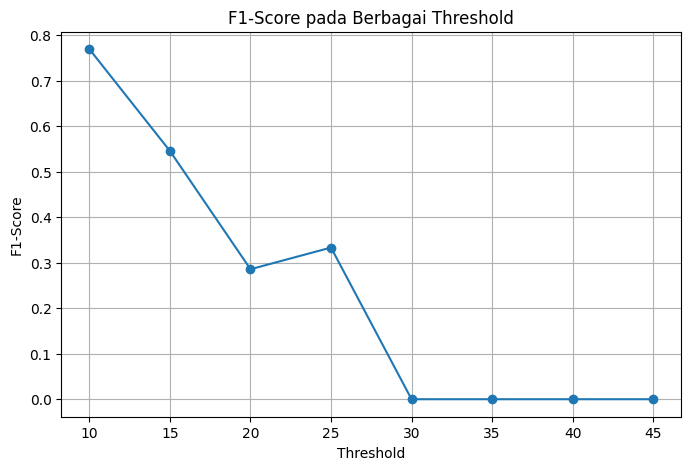

In [14]:
# Menampilkan hasil F1-Score untuk setiap threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='o')
plt.title("F1-Score pada Berbagai Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.grid()
plt.show()

In [15]:
# Menentukan plagiasi berdasarkan threshold optimal
print("Menentukan plagiasi berdasarkan threshold optimal...")
final_predicted_labels = [1 if matches > optimal_threshold else 0 for matches in simulated_matches]
for (filename, matches), label in zip(match_counts, final_predicted_labels):
    status = "Plagiasi" if label == 1 else "Tidak Plagiasi"
    print(f"Gambar: {filename}, Jumlah fitur cocok: {matches}, Status: {status}")

Menentukan plagiasi berdasarkan threshold optimal...
Gambar: tt0084058.jpg, Jumlah fitur cocok: 26, Status: Plagiasi
Gambar: tt0084867.jpg, Jumlah fitur cocok: 21, Status: Plagiasi
Gambar: tt0085121.jpg, Jumlah fitur cocok: 16, Status: Plagiasi
Gambar: tt0085154.jpg, Jumlah fitur cocok: 14, Status: Plagiasi
Gambar: tt0085159.jpg, Jumlah fitur cocok: 8, Status: Tidak Plagiasi
Gambar: tt0085208.jpg, Jumlah fitur cocok: 18, Status: Plagiasi
Gambar: tt0085236.jpg, Jumlah fitur cocok: 12, Status: Plagiasi
Gambar: tt0085244.jpg, Jumlah fitur cocok: 18, Status: Plagiasi
Gambar: tt0085248.jpg, Jumlah fitur cocok: 17, Status: Plagiasi
Gambar: tt0085255.jpg, Jumlah fitur cocok: 9, Status: Tidak Plagiasi
Gambar: tt0085271.jpg, Jumlah fitur cocok: 20, Status: Plagiasi
Gambar: tt0085276.jpg, Jumlah fitur cocok: 10, Status: Tidak Plagiasi
Gambar: tt0085318.jpg, Jumlah fitur cocok: 27, Status: Plagiasi
Gambar: tt0085320.jpg, Jumlah fitur cocok: 28, Status: Plagiasi
Gambar: tt0085333.jpg, Jumlah fitur